In [ ]:
!pip install torch torchvision torchaudio
# Install torch-scatter
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install torch-sparse
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install torch-cluster
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Install torch-geometric
!pip install torch-geometric

In [1]:
!pip install pandas
!pip install networkx

import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
# from google.colab import files

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [225]:
# from google.colab import drive
# drive.mount('/content/drive')
dataset_path = 'simulator_data.csv'
# dataset_path = '/content/simulator_data.csv'
# df = pd.read_csv(dataset_path)


In [226]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
from torch_geometric.data import Data
import numpy as np

# Load the dataset
# dataset_path = "path_to_your_dataset.csv"  # Replace with your actual dataset path
data = pd.read_csv(dataset_path)

# Function to compute the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


In [227]:
# Function to check for handovers between timestamps
def check_handovers(df, current_timestamp, next_timestamp):
    current_data = df[df['timestamp'] == current_timestamp]
    next_data = df[df['timestamp'] == next_timestamp]

    handovers = {}
    for vid in current_data['vehicleId'].unique():
        current_master = current_data[current_data['vehicleId'] == vid]['masterId'].iloc[0]
        next_master = next_data[next_data['vehicleId'] == vid]['masterId'].iloc[0] if vid in next_data['vehicleId'].values else current_master
        handovers[vid] = current_master != next_master

    return handovers

In [228]:
# Function to create a graph data object and NetworkX graph for a given timestamp
def create_graph_data_for_timestamp(df, timestamp):
    timestamp_data = df[df['timestamp'] == timestamp]
    vehicle_ids = timestamp_data['vehicleId'].unique()
    print('number of vehicles:', vehicle_ids.size)
    tower_ids = timestamp_data['towerId'].unique()
    print('number of towers:', tower_ids.size)
    vehicle_mapping = {vid: i for i, vid in enumerate(vehicle_ids)}
    tower_mapping = {tid: i + len(vehicle_ids) for i, tid in enumerate(tower_ids)}

    node_features = []
    edge_index = []
    edge_features = []

    G = nx.Graph()  # NetworkX Graph for visualization

    # Process vehicle nodes
    for vid in vehicle_ids:
        
        vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        vehicle_features = [
            vehicle_data['vehicleSpeed'], vehicle_data['vehicleDirection'],
            vehicle_data['signalQuality'], vehicle_data['vehiclePosX'],
            vehicle_data['vehiclePosY']
        ]
        node_features.append(vehicle_features)
        G.add_node(vehicle_mapping[vid], pos=(vehicle_data['vehiclePosX'], vehicle_data['vehiclePosY']),
                   type='vehicle', label=f'{vid}')

    # Process tower nodes
    for tid in tower_ids:
        master_data = timestamp_data[timestamp_data['masterId'] == tid][::-1]
        if not master_data.empty:
            tower_data = master_data.iloc[0]
            tower_features = [
                tower_data['masterPosX'], tower_data['masterPosY'],
                tower_data['masterLoad'], 0.0, 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['masterPosX'], tower_data['masterPosY']), load=tower_data['masterLoad'],
                    type='tower', label=f'T{tid}')
        else:
            tower_data = timestamp_data[timestamp_data['towerId'] == tid][::-1].iloc[0]
            tower_features = [
                tower_data['towerPosX'], tower_data['towerPosY'],
                tower_data['towerLoad'], 0.0, 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['towerPosX'], tower_data['towerPosY']), load=tower_data['towerLoad'],
                        type='tower', label=f'T{tid}')

        node_features.append(tower_features)
        

    # Add edges based on the masterId
    for _, row in timestamp_data.iterrows():
        vehicle_id = vehicle_mapping[row['vehicleId']]
        tower_id = tower_mapping[row['masterId']]  # Connect to the master tower
        edge_index.append([vehicle_id, tower_id])

        distance = calculate_distance(row['vehiclePosX'], row['vehiclePosY'],
                                      row['masterPosX'], row['masterPosY'])
        edge_features.append([row['signalQuality'], row['masterRssi'], distance])

        # Add edges to the NetworkX graph
        G.add_edge(vehicle_id, tower_id, distance=distance, rssi=row['masterRssi'])
    
    node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)

    graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_features_tensor)

    return graph_data, G, vehicle_mapping, tower_mapping

number of vehicles: 31
number of towers: 10


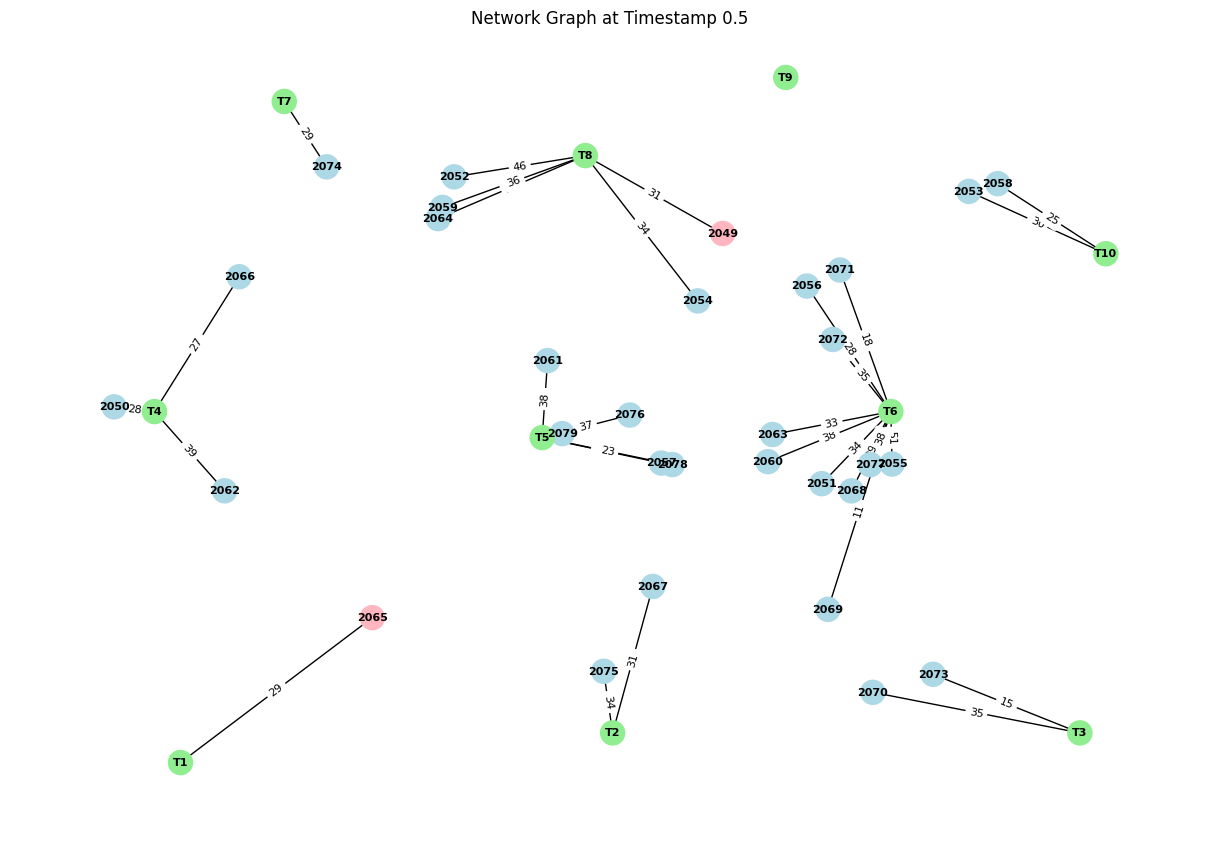

number of vehicles: 81
number of towers: 10


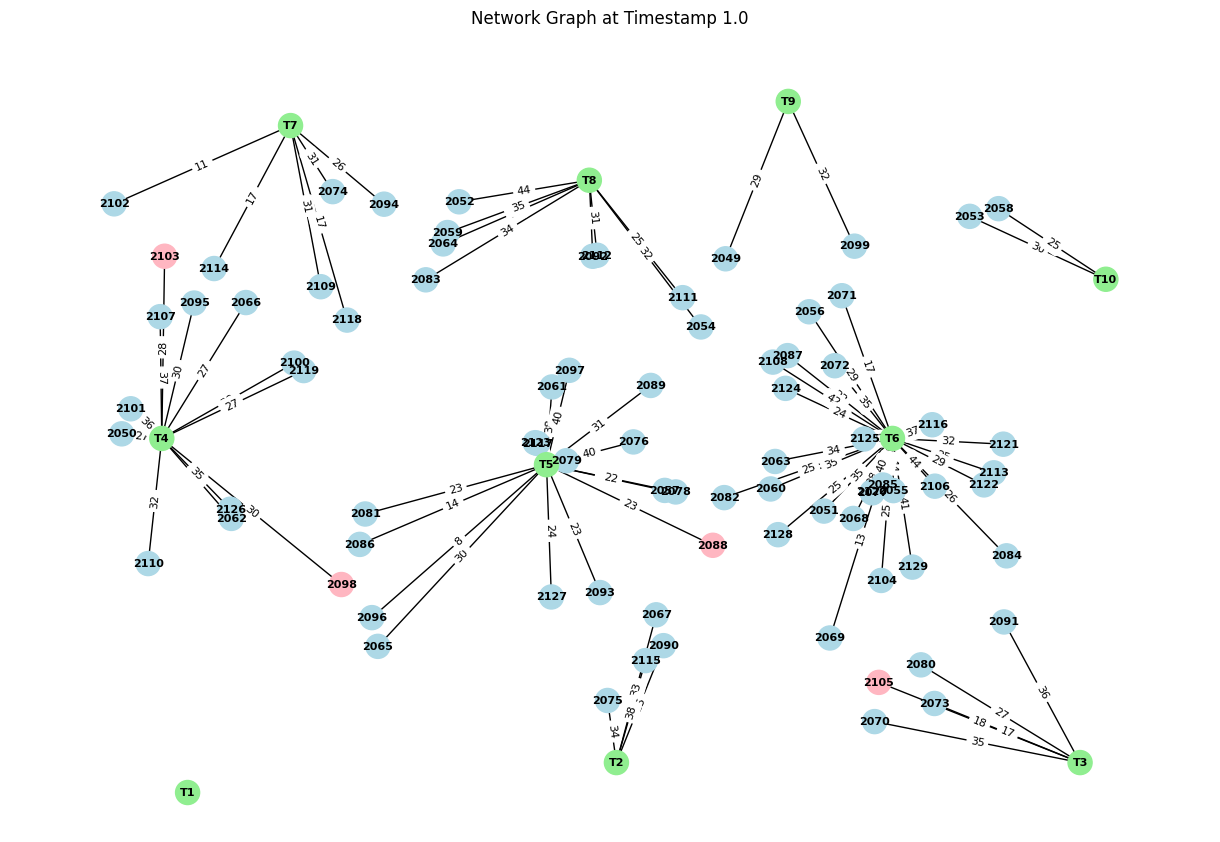

number of vehicles: 99
number of towers: 10


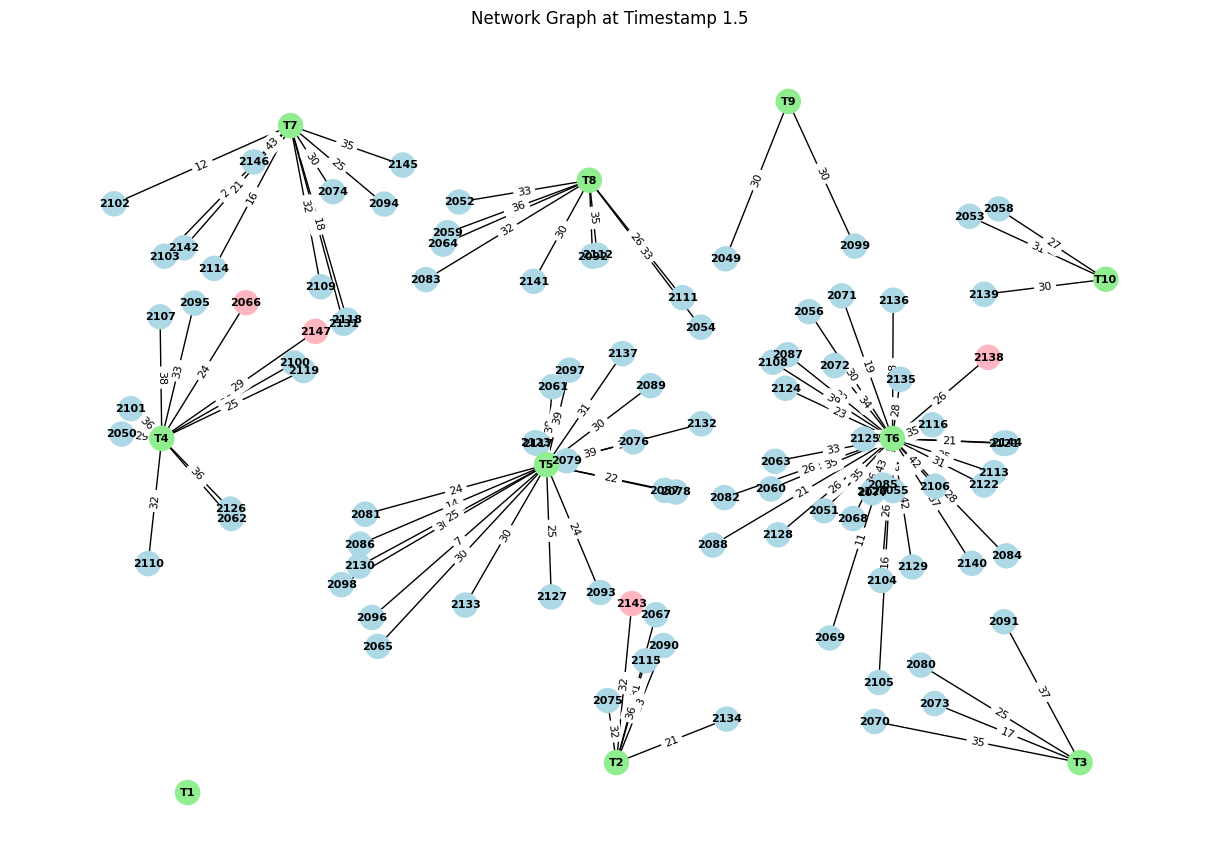

In [231]:
# Visualization function
def visualize_graph(G, handovers, vehicle_mapping, tower_mapping):
    # Set node attributes for vehicle and tower IDs and colors
    for node in G.nodes:
        node_info = G.nodes[node]
        node_type = node_info['type']
        if node_type == 'vehicle':
            label = node_info['label']
            color = 'lightblue'  # Color for vehicles
        elif node_type == 'tower':
            label = node_info['label']
            color = 'lightgreen'  # Color for towers
        else:
            label = 'Unknown'
            color = 'gray'

        G.nodes[node]['label'] = label
        G.nodes[node]['color'] = color

    # Highlight handover nodes
    for vehicle_id, handover in handovers.items():
        if handover:
            node = vehicle_mapping.get(vehicle_id)
            if node is not None:
                G.nodes[node]['color'] = 'lightpink'  # Highlight color for handovers

    # Set edge attributes for master RSSI
    for u, v in G.edges:
        edge_data = G[u][v]
        # Ensure that the 'masterRssi' key is correctly named as per your data
        master_rssi = edge_data.get('rssi', 0.0)  # Default to 'N/A' if not available
        G.edges[u, v]['label'] = str(int(master_rssi))

    # Prepare colors for nodes
    node_colors = [G.nodes[node]['color'] for node in G.nodes]

    # Visualize the graph
    pos = nx.get_node_attributes(G, 'pos')
    scale_factor = 100
    # Scale the x and y coordinates of each node
    scaled_pos = {node: (x * scale_factor, y * scale_factor) for node, (x, y) in pos.items()}
    nx.set_node_attributes(G, scaled_pos, 'pos')

    nx.draw(G, pos=scaled_pos, node_color=node_colors, with_labels=True, labels=nx.get_node_attributes(G, 'label'),font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos=scaled_pos, edge_labels=nx.get_edge_attributes(G, 'label'),font_size=8)


# Function to visualize graphs for all timestamps within a specified range
def visualize_for_timestamp_range(df, start_timestamp, end_timestamp):
    # Filter timestamps within the specified range
    timestamps = df['timestamp'].unique()
    timestamps_in_range = [t for t in timestamps if start_timestamp <= t <= end_timestamp]

    for timestamp in timestamps_in_range:
        # Get the next timestamp in the sequence for handover comparison
        next_timestamp_index = np.where(timestamps == timestamp)[0][0] + 1
        if next_timestamp_index < len(timestamps):
            next_timestamp = timestamps[next_timestamp_index]
        else:
            next_timestamp = timestamp  # No handover if it's the last timestamp

        # Check for handovers and create the graph for the current timestamp
        handovers = check_handovers(df, timestamp, next_timestamp)
        _, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(df, timestamp)

        # Visualize the graph
        plt.figure(figsize=(12, 8))
        visualize_graph(G, handovers, vehicle_mapping, tower_mapping)
        plt.title(f'Network Graph at Timestamp {timestamp}')
        plt.show()

# Example usage: Visualize graphs for a range of timestamps
visualize_for_timestamp_range(data, start_timestamp=0.5, end_timestamp=1.5)